In [1]:
%load_ext autoreload

In [2]:
import sys
import warnings 

sys.path.append("../..")
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from scipy import stats

from source.models.stochastic import MISOSystem

In [285]:
class RecursiveLeastSquaresEstimator:
    def __init__(self, forgetting: float = 1.0, initial_condition_scale: float = 500.0):
        self.forgetting = forgetting
        self.initial_condition_scale = initial_condition_scale
        self.theta = None
        self.gains = None
        self.p = None

    def fit_predict(self, x, y):
        self.theta = np.zeros(x.shape)
        self.gains = np.zeros(x.shape)
        self.p = np.zeros([x.shape[0], x.shape[1], x.shape[1]])
        self.p[0] = np.eye(x.shape[1])
        
        for time_step in range(1, x.shape[0]):
            self.p[time_step] = self.current_p(self.p[time_step-1], x[time_step])
            self.gains[time_step] = self.get_gain(self.p[time_step - 1], x[time_step], y[time_step])[:, 0]
            self.theta[time_step] = self.theta[time_step - 1] - (self.gains[time_step] * self.estimation_error(x[time_step], y[time_step], self.theta[time_step - 1]))
    
    def current_p(self, past_p, x):
        x = x.reshape(x.shape + (1, ))
        return past_p - past_p @ x @  np.linalg.inv(1 + x.T @ past_p @ x) @ x.T @ past_p
    
    def get_gain(self, p, x, y):
        x = x.reshape(x.shape + (1, ))
        return p @ x @ np.linalg.inv(1 + x.T @ p @ x)
        
    def estimation_error(self, x, y, theta):
        return (x.T @ theta - y)
    
    def gains(self, x, y):
        return np.eye(x.shape[0])

In [286]:
rls = RecursiveLeastSquaresEstimator()

In [287]:
system = MISOSystem(coefficients=np.array([1, 2, 3, 4]))

In [288]:
x = stats.multivariate_normal.rvs(cov=np.eye(4), size=1000)
y = system.apply(x, variance=0.1)

In [289]:
rls.fit_predict(x, y)

In [290]:
rls.theta.shape

(1000, 4)

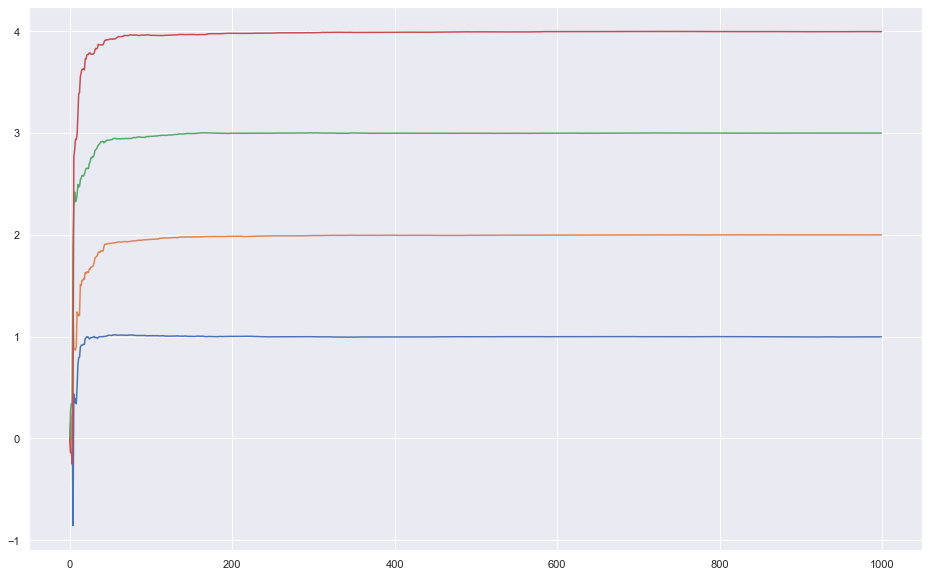

In [291]:
figure = plt.figure(figsize=[16, 10])
_ = plt.plot(rls.theta[:, 0])
_ = plt.plot(rls.theta[:, 1])
_ = plt.plot(rls.theta[:, 2])
_ = plt.plot(rls.theta[:, 3])